In [54]:
import os
import sys
import pandas as pd
import numpy as np
from descartes import PolygonPatch
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.dirname(os.getcwd()))
import alphashape
import cv2
import sklearn
import tensorflow as tf
import open3d as o3d
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import math
from PIL import Image

/tmp/ipykernel_17752/142025742.py:62: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in alpha_shape]


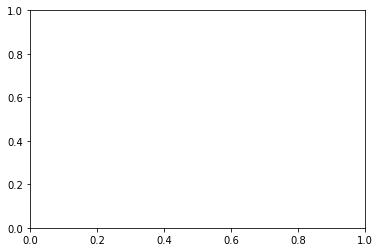

In [59]:
files = ['Data/lidar tests/training/' + file for file in os.listdir('Data/lidar tests/training')]
dataset = tf.data.TFRecordDataset(files, buffer_size=tf.constant(int(pow(10,6)), tf.int64), num_parallel_reads=16)
OUTPUT_PATH = 'Data/darknet-data'
SCALE_PCT = 0.5
img_id = len(os.listdir(f'{OUTPUT_PATH}/obj')) // 2

def label_in_polygon(label, image):
    top_left_x = int(math.ceil(label.box.center_x - label.box.length / 2))
    top_left_y = int(math.ceil(label.box.center_y - label.box.width / 2))
    bottom_right_x = int(math.ceil(label.box.center_x + label.box.length / 2))
    bottom_right_y = int(math.ceil(label.box.center_y + label.box.width / 2))
    cropped = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
    nb_pixels = cropped.size
    nonzero = np.count_nonzero(cropped)
    return (nonzero / nb_pixels) > 0.25

training_index = open('Data/darknet-data/training.txt', 'w')
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    image = frame.images[0]
    image = np.array(tf.io.decode_jpeg(image.image))

    if np.mean(image) < 100:
        continue

    (range_images, camera_projections, _, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)
    points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
    points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
        frame,
        range_images,
        camera_projections,
        range_image_top_pose,
        ri_index=1)
    # 3d points in vehicle frame.
    points_all = np.concatenate(points, axis=0)
    points_all_ri2 = np.concatenate(points_ri2, axis=0)
    # camera projection corresponding to each point.
    cp_points_all = np.concatenate(cp_points, axis=0)
    cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

    all_points = np.append(points_all, points_all_ri2, axis=0)
    all_points_cp = np.append(cp_points_all, cp_points_all_ri2, axis=0)

    front_points = np.array([point for (point, cp) in zip(all_points, all_points_cp) if cp[0] == 1 or cp[3] == 1])
    front_cp_points = np.array([cp[:3] if cp[0] == 1 else cp[3:] for cp in all_points_cp if cp[0] == 1 or cp[3] == 1])

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(front_points)
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.1, ransac_n=4, num_iterations=1000)

    front_cp_points_no_road = np.delete(front_cp_points, inliers, axis=0)

    alpha_shape = alphashape.alphashape(front_cp_points_no_road[:,1:3], 0.02)
    int_coords = lambda x: np.array(x).round().astype(np.int32)

    try:
        exteriors = [int_coords(poly.exterior.coords) for poly in alpha_shape]
    except:
        exteriors = [int_coords(poly.exterior.coords) for poly in [alpha_shape]]

    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.fillPoly(mask, exteriors, 1)
    image = cv2.bitwise_and(image, image, mask=mask)

    labels = [camera_labels.labels for camera_labels in frame.camera_labels if camera_labels.name == 1][0]
    labels = [label for label in labels if label.box.length > 50 and label.box.length > 50 and label_in_polygon(label, image)]

    og_width = image.shape[1]
    og_height = image.shape[0]
    img_width = int(og_width * SCALE_PCT)
    img_height = int(og_height * SCALE_PCT)
    image = Image.fromarray(image)    
    image = image.resize((img_width, img_height))

    image_name = f'example-{img_id}.jpg'
    image.save(f'{OUTPUT_PATH}/obj/{image_name}')

    label_name = f'example-{img_id}.txt'
    with open(f'{OUTPUT_PATH}/obj/{label_name}', 'w') as label_file:
        for label in labels:
            cx = label.box.center_x 
            cy = label.box.center_y
            w = label.box.length
            h = label.box.width
            cx /= og_width
            cy /= og_height
            w /= og_width
            h /= og_height
            clazz = label.type
            darknet_labels = f'{clazz} {cx} {cy} {w} {h}\n'
            label_file.write(darknet_labels)

    training_index.write(f'data/obj/{image_name}\n')
    img_id += 1

training_index.close()
    

In [61]:
files = ['Data/lidar tests/validation/' + file for file in os.listdir('Data/lidar tests/validation')]

validation_index = open('Data/darknet-data/validation.txt', 'w')
img_id = len(os.listdir(f'{OUTPUT_PATH}/obj')) // 2
def label_in_polygon(label, image):
    top_left_x = int(math.ceil(label.box.center_x - label.box.length / 2))
    top_left_y = int(math.ceil(label.box.center_y - label.box.width / 2))
    bottom_right_x = int(math.ceil(label.box.center_x + label.box.length / 2))
    bottom_right_y = int(math.ceil(label.box.center_y + label.box.width / 2))
    cropped = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
    nb_pixels = cropped.size
    nonzero = np.count_nonzero(cropped)
    return (nonzero / nb_pixels) > 0.25


for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    image = frame.images[0]
    image = np.array(tf.io.decode_jpeg(image.image))

    if np.mean(image) < 100:
        continue

    (range_images, camera_projections, _, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)
    points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
    points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
        frame,
        range_images,
        camera_projections,
        range_image_top_pose,
        ri_index=1)
    # 3d points in vehicle frame.
    points_all = np.concatenate(points, axis=0)
    points_all_ri2 = np.concatenate(points_ri2, axis=0)
    # camera projection corresponding to each point.
    cp_points_all = np.concatenate(cp_points, axis=0)
    cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

    all_points = np.append(points_all, points_all_ri2, axis=0)
    all_points_cp = np.append(cp_points_all, cp_points_all_ri2, axis=0)

    front_points = np.array([point for (point, cp) in zip(all_points, all_points_cp) if cp[0] == 1 or cp[3] == 1])
    front_cp_points = np.array([cp[:3] if cp[0] == 1 else cp[3:] for cp in all_points_cp if cp[0] == 1 or cp[3] == 1])

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(front_points)
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.1, ransac_n=4, num_iterations=1000)

    front_cp_points_no_road = np.delete(front_cp_points, inliers, axis=0)

    alpha_shape = alphashape.alphashape(front_cp_points_no_road[:,1:3], 0.02)
    int_coords = lambda x: np.array(x).round().astype(np.int32)

    try:
        exteriors = [int_coords(poly.exterior.coords) for poly in alpha_shape]
    except:
        exteriors = [int_coords(poly.exterior.coords) for poly in [alpha_shape]]

    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.fillPoly(mask, exteriors, 1)
    image = cv2.bitwise_and(image, image, mask=mask)

    labels = [camera_labels.labels for camera_labels in frame.camera_labels if camera_labels.name == 1][0]
    labels = [label for label in labels if label.box.length > 50 and label.box.length > 50 and label_in_polygon(label, image)]

    og_width = image.shape[1]
    og_height = image.shape[0]
    img_width = int(og_width * SCALE_PCT)
    img_height = int(og_height * SCALE_PCT)
    image = Image.fromarray(image)
    image = image.resize((img_width, img_height))

    image_name = f'example-{img_id}.jpg'
    image.save(f'{OUTPUT_PATH}/obj/{image_name}')

    label_name = f'example-{img_id}.txt'
    with open(f'{OUTPUT_PATH}/obj/{label_name}', 'w') as label_file:
        for label in labels:
            cx = label.box.center_x 
            cy = label.box.center_y
            w = label.box.length
            h = label.box.width
            cx /= og_width
            cy /= og_height
            w /= og_width
            h /= og_height
            clazz = label.type
            darknet_labels = f'{clazz} {cx} {cy} {w} {h}\n'
            label_file.write(darknet_labels)

    validation_index.write(f'data/obj/{image_name}\n')
    img_id += 1

validation_index.close()